In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [48]:
한화에어로스페이스 = pd.read_csv('/content/drive/My Drive/주가 예측 프로젝트/한화에어로스페이스.csv', parse_dates= ['일자'])
외인기관매매량 = pd.read_csv('/content/drive/My Drive/주가 예측 프로젝트/한화에어로_외인기관매매량.csv')

In [49]:
한화에어로스페이스 = pd.concat([한화에어로스페이스, 외인기관매매량], axis = 1)
한화에어로스페이스 = 한화에어로스페이스.sort_values(['일자']).reset_index(drop = True)

In [51]:
import re

def str_to_int(x):
    x = re.sub(',', '', x)
    return int(x)

columns = ['종가', '전일비', '시가', '고가', '저가', '거래량']

for i in columns:
    한화에어로스페이스[i] = 한화에어로스페이스[i].apply(str_to_int)

In [52]:
# 5, 20, 60, 120 이동평균 

def MA(data, N, col):
    MA = pd.Series.rolling(data[col], window = N, center = False).mean()
    data['MA_'+str(N)] = MA
    return data

한화에어로스페이스 = MA(한화에어로스페이스, 5, '종가')
한화에어로스페이스 = MA(한화에어로스페이스, 20, '종가')
한화에어로스페이스 = MA(한화에어로스페이스, 60, '종가')
한화에어로스페이스 = MA(한화에어로스페이스, 120, '종가')

In [53]:
# RSI

def RSI(data, N, col):
    U = np.where(data[col].diff(1) > 0, data[col].diff(1), 0)
    D = np.where(data[col].diff(1) < 0, data[col].diff(1) * (-1), 0)
    
    AU = pd.DataFrame(U).rolling(window = N, min_periods = N).mean()
    AD = pd.DataFrame(D).rolling(window = N, min_periods = N).mean()
    RSI = AU.div(AD + AU) * 100
    return RSI

In [54]:
한화에어로스페이스['RSI'] = RSI(한화에어로스페이스, 14, '종가')
한화에어로스페이스['RSI_signal'] = 한화에어로스페이스['RSI'].rolling(window = 9).mean()

In [55]:
# MACD

def MACD(data, N1, N2, N_signal):
    data['EMAFast'] = data['종가'].ewm(span = N1, min_periods = N1-1).mean()
    data['EMASlow'] = data['종가'].ewm(span = N2, min_periods = N2-1).mean()
    
    data['MACD'] = data['EMAFast'] - data['EMASlow']
    data['MACD_signal'] = data['MACD'].ewm(span = N_signal, min_periods = N_signal-1).mean()
    data['MACD_diff'] = data['MACD'] - data['MACD_signal']
    return data

한화에어로스페이스 = MACD(한화에어로스페이스, 12, 26, 9)

In [56]:
한화에어로스페이스['MA_5_20_diff'] = 한화에어로스페이스['MA_5'] - 한화에어로스페이스['MA_20']

In [57]:
%%time

def goldencross(data, col, colname):
    data[str(colname) + '_goldencross'] = 0
    for i in range(1, len(data)):
        if (data[col][i-1] < 0) & (data[col][i] > 0):
            data[str(colname) + '_goldencross'][i] = 1
        else:
            data[str(colname) + '_goldencross'][i] = 0
    return data
            
def deadcross(data, col, colname):
    data[str(colname) + '_deadcross'] = 0
    for i in range(1, len(data)):
        if (data[col][i-1] > 0) & (data[col][i] < 0):
            data[str(colname) + '_deadcross'][i] = 1
        else:
            data[str(colname) + '_deadcross'][i] = 0
    return data
            
한화에어로스페이스 = goldencross(한화에어로스페이스, 'MA_5_20_diff', 'MA')
한화에어로스페이스 = goldencross(한화에어로스페이스, 'MACD_diff', 'MACD')

한화에어로스페이스 = deadcross(한화에어로스페이스, 'MA_5_20_diff', 'MA')
한화에어로스페이스 = deadcross(한화에어로스페이스, 'MACD_diff', 'MACD')

CPU times: user 474 ms, sys: 0 ns, total: 474 ms
Wall time: 478 ms


In [58]:
def 매매량_to_int(x):
    x = re.sub(',', '', x)
    x = re.sub('\+', '', x)
    return int(x)

한화에어로스페이스['기관매매량'] = 한화에어로스페이스['기관매매량'].apply(매매량_to_int)
한화에어로스페이스['외인매매량'] = 한화에어로스페이스['외인매매량'].apply(매매량_to_int)

In [59]:
%%time

def 전일비(data, col):
    data['전일비(%)'] = 0
    data['전일비(원)'] = 0
    for i in range(1, len(data)):
        data['전일비(원)'][i] = data[col][i] - data[col][i-1]
        전일비퍼센트 = (data['전일비(원)'][i] / data[col][i-1]) * 100
        data['전일비(%)'][i] = '%0.2f' % 전일비퍼센트
    return data

한화에어로스페이스 = 전일비(한화에어로스페이스, '종가')
한화에어로스페이스.drop(['전일비'], axis = 1, inplace = True)

CPU times: user 238 ms, sys: 64 µs, total: 238 ms
Wall time: 238 ms


In [60]:
def labeling(x):
    if x > 0:
        return 1
    else:
        return 0
    
한화에어로스페이스['LABEL'] = 한화에어로스페이스['전일비(원)'].apply(labeling) 

In [61]:
한화에어로스페이스.dropna(axis = 0, inplace = True)
한화에어로스페이스.reset_index(drop = True, inplace = True)

## 시각화

In [62]:
!pip install mplfinance

In [63]:
from mplfinance.original_flavor import candlestick2_ohlc
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [64]:
한화에어로스페이스.columns

Index(['일자', '종가', '시가', '고가', '저가', '거래량', '기관매매량', '외인매매량', 'MA_5', 'MA_20',
       'MA_60', 'MA_120', 'RSI', 'RSI_signal', 'EMAFast', 'EMASlow', 'MACD',
       'MACD_signal', 'MACD_diff', 'MA_5_20_diff', 'MA_goldencross',
       'MACD_goldencross', 'MA_deadcross', 'MACD_deadcross', '전일비(%)',
       '전일비(원)', 'LABEL'],
      dtype='object')

In [74]:
한화에어로스페이스 = 한화에어로스페이스.iloc[1000:,:]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

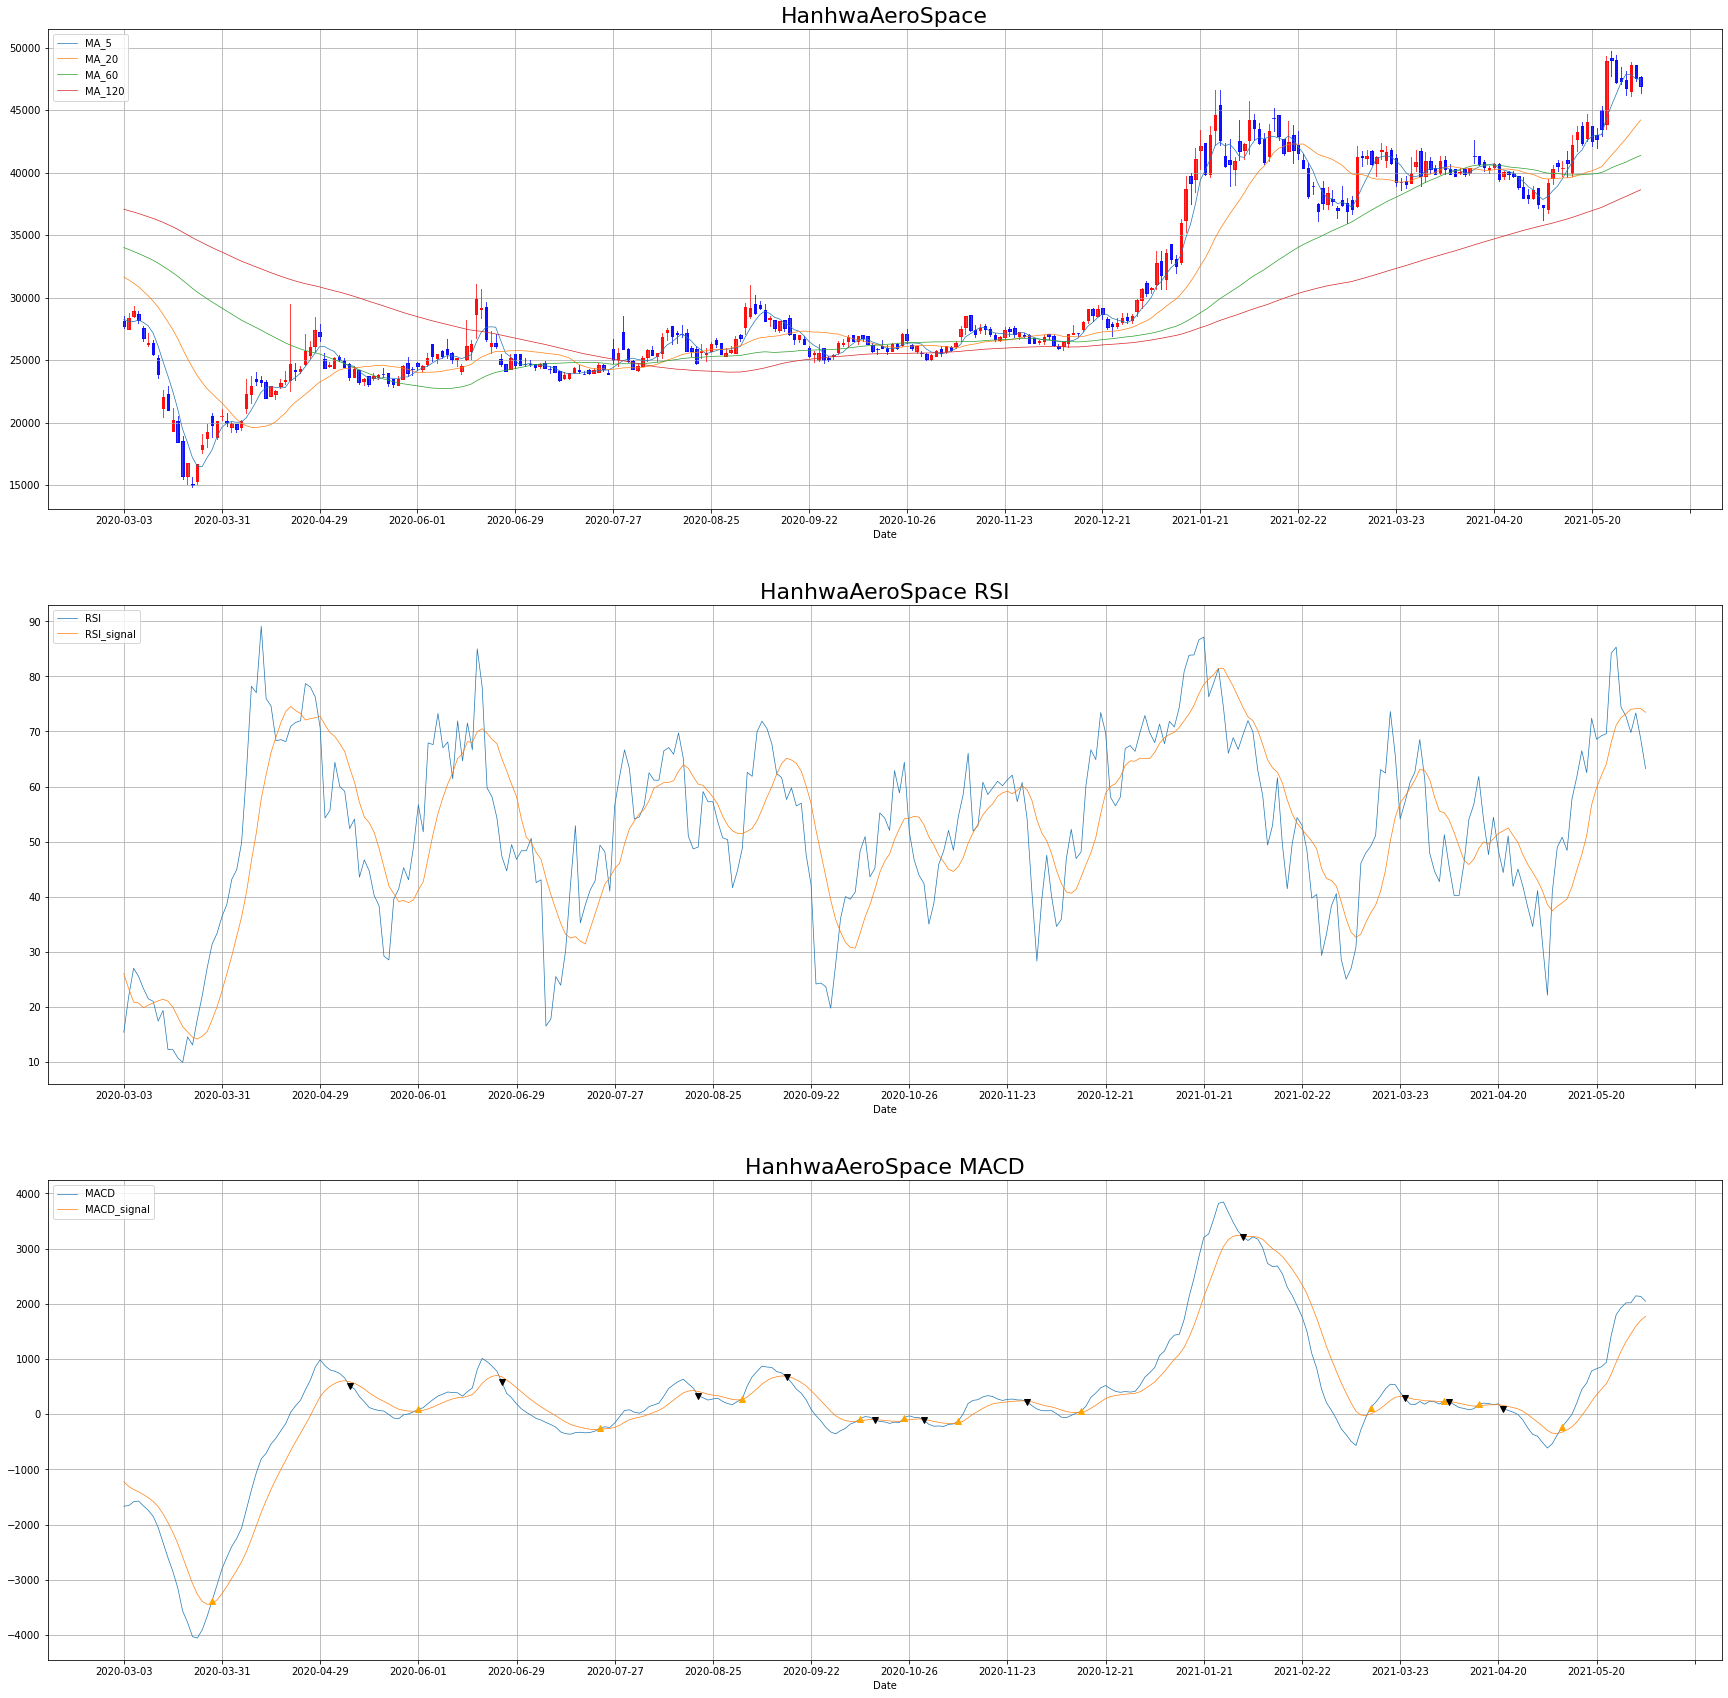

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (30, 30))
index = 한화에어로스페이스['일자'].astype('str')

# 이평선
ax1.plot(index, 한화에어로스페이스['MA_5'], label = 'MA_5', linewidth = 0.7)
ax1.plot(index, 한화에어로스페이스['MA_20'], label = 'MA_20', linewidth = 0.7)
ax1.plot(index, 한화에어로스페이스['MA_60'], label = 'MA_60', linewidth = 0.7)
ax1.plot(index, 한화에어로스페이스['MA_120'], label = 'MA_120', linewidth = 0.7)

# X축 티커 숫자 20개로 제한
ax1.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax2.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax3.xaxis.set_major_locator(ticker.MaxNLocator(20))

# 그래프 title과 축 이름 지정
ax1.set_title('HanhwaAeroSpace', fontsize = 22)
ax1.set_xlabel('Date')
ax2.set_title('HanhwaAeroSpace RSI', fontsize = 22)
ax2.set_xlabel('Date')
ax3.set_title('HanhwaAeroSpace MACD', fontsize = 22)
ax3.set_xlabel('Date')

# 캔들차트 그리기
candlestick2_ohlc(ax1, 
                  한화에어로스페이스['시가'],
                  한화에어로스페이스['고가'],
                  한화에어로스페이스['저가'],
                  한화에어로스페이스['종가'],
                  width = 0.5,
                  colorup = 'r',
                  colordown = 'b')

# RSI
ax2.plot(index, 한화에어로스페이스['RSI'], label = 'RSI', linewidth = 0.7)
ax2.plot(index, 한화에어로스페이스['RSI_signal'], label = 'RSI_signal', linewidth = 0.7)

# MACD
ax3.plot(index, 한화에어로스페이스['MACD'], label = 'MACD', linewidth = 0.7)
ax3.plot(index, 한화에어로스페이스['MACD_signal'], label = 'MACD_signal', linewidth = 0.7)
ax3.plot(한화에어로스페이스.loc[한화에어로스페이스['MACD_goldencross'] == 1]['일자'].astype('str'), 한화에어로스페이스.loc[한화에어로스페이스['MACD_goldencross'] == 1]['MACD'], '^', color = 'orange')
ax3.plot(한화에어로스페이스.loc[한화에어로스페이스['MACD_deadcross'] == 1]['일자'].astype('str'), 한화에어로스페이스.loc[한화에어로스페이스['MACD_deadcross'] == 1]['MACD'], 'v', color = 'k')

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper left')
ax3.legend(loc = 'upper left')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

In [76]:
from fbprophet import Prophet 

In [77]:
prop_train = 한화에어로스페이스[['일자', '종가']]

In [78]:
prop_train.rename({'일자':'ds', '종가':'y'}, inplace = True, axis = 1)

In [79]:
prophet_model = Prophet(changepoint_prior_scale=0.2, daily_seasonality = 5, seasonality_mode='multiplicative')
prophet_model.fit(prop_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [80]:
future = prophet_model.make_future_dataframe(periods= 10, freq='D')
forecast = prophet_model.predict(future)

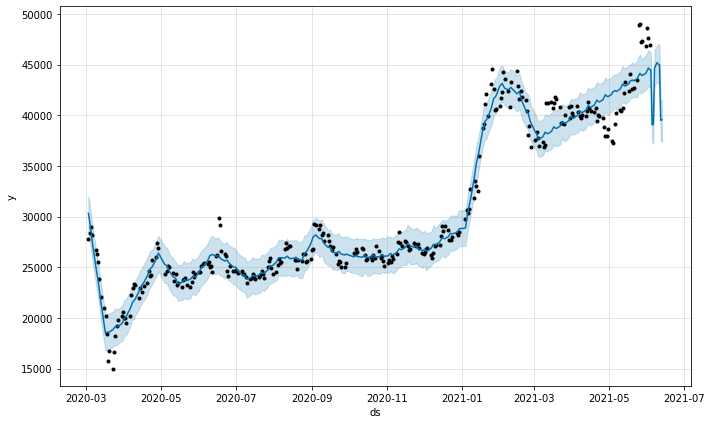

In [81]:
fig1 = prophet_model.plot(forecast)

In [83]:
forecast[310::]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
310,2021-06-03,2841.135942,42755.082141,46336.747355,2841.135942,2841.135942,14.106814,14.106814,14.106814,14.675286,14.675286,14.675286,0.568472,0.568472,0.568472,0.0,0.0,0.0,44535.617816
311,2021-06-04,2845.922060,42805.589587,46215.498122,2845.922060,2845.922060,14.106814,14.106814,14.106814,14.619816,14.619816,14.619816,0.513002,0.513002,0.513002,0.0,0.0,0.0,44452.778045
312,2021-06-05,2850.708179,37353.949604,40861.014629,2850.708179,2850.708179,14.106814,14.106814,14.106814,12.696133,12.696133,12.696133,-1.410681,-1.410681,-1.410681,0.0,0.0,0.0,39043.677015
313,2021-06-06,2855.494297,37216.045917,40814.903742,2855.494297,2855.494297,14.106814,14.106814,14.106814,12.696133,12.696133,12.696133,-1.410681,-1.410681,-1.410681,0.0,0.0,0.0,39109.228329
314,2021-06-07,2860.280416,42837.917278,46504.404118,2860.280416,2860.280416,14.106814,14.106814,14.106814,14.621302,14.621302,14.621302,0.514488,0.514488,0.514488,0.0,0.0,0.0,44681.305380
315,2021-06-08,2865.066534,43120.545700,46687.284547,2861.886230,2869.224835,14.106814,14.106814,14.106814,14.688178,14.688178,14.688178,0.581364,0.581364,0.581364,0.0,0.0,0.0,44947.674357
316,2021-06-09,2869.852653,43365.374010,46910.423310,2858.718989,2879.512270,14.106814,14.106814,14.106814,14.750850,14.750850,14.750850,0.644036,0.644036,0.644036,0.0,0.0,0.0,45202.619511
317,2021-06-10,2874.638772,43158.127902,47055.834637,2853.173501,2892.418355,14.106814,14.106814,14.106814,14.675286,14.675286,14.675286,0.568472,0.568472,0.568472,0.0,0.0,0.0,45060.784253
318,2021-06-11,2879.424890,43046.877108,46892.644915,2847.597027,2904.913227,14.106814,14.106814,14.106814,14.619816,14.619816,14.619816,0.513002,0.513002,0.513002,0.0,0.0,0.0,44976.086078
319,2021-06-12,2884.211009,37463.076315,41426.072107,2836.559220,2922.785800,14.106814,14.106814,14.106814,12.696133,12.696133,12.696133,-1.410681,-1.410681,-1.410681,0.0,0.0,0.0,39502.536217
